In [2]:
from google.colab import files
files.upload()

Saving proced_data.zip to proced_data.zip


{'proced_data.zip': b'PK\x03\x04\x14\x00\x08\x00\x08\x00T\xbcrQ\x00\x00\x00\x00\x00\x00\x00\x00&\xca\x03\x00\t\x00 \x00vocab.txtUT\r\x00\x07\x001\xb5_\xaa2\xb5_\xa82\xb5_ux\x0b\x00\x01\x04\xf5\x01\x00\x00\x04\x14\x00\x00\x00l\xbd\xcdr\x1bY\x93%\xb8\xc7\xbb\x8c\xd9\x97\xdfOM\xb7Y[\x9b\xf5t\xcfj\xc6z\xca\xacl\xd6\xb3\xec\xdd\xf4\xa2_\x00$\x83J\x88\x84\x92`\n \x83$\xc0\x0c\xa6@\x01TB\x95A2D\x81\x9f\xc0\xcaw\x99\xda1\x02\xef0~\xceq\xbf\x11P\xb5\x19M\x99\xa2\xc8@\xc4\x8d{\xfd\xe7\xf8\xf1\xe3\xff\xe1\x1f\xff\xd3\x7f\xf9\x8f\xbd\xff\xf0O\xff\xd7?\xd9\x9f\xff\xfb\x7f\xc5\xff\xff\xdf\xff\xf5\xff\xf8\x8f\xbdf2\xd8N\xf2\xfah\xdc{\xbd/\x9b\xc5\xfbz4\xed5\xd77\xf5\xc9E\xb3\xbf\xaa\x8f\x07\xf5\xfby}<\xef5\xd9\xfd\xeb\xe3\x17\xfb\xc9\xd7\xf5\xba\xd7\xcc\xaa\xedq\xbf^\x0c\x9b\xf3\x91\xfd\xf0i3\xeb\xbf>\x1c\xf0/\x07{\xdb\x8b\xbbf\xb6n\x16\xfd^\xfd\xd4\xaf\x9f\xb2f\x96\xf5\x9a\x0f/\xf6\x1f\xfb\x80^\xbd\xbfl\xaeG\xcdE\xbf\x99\xe5=|\x02~\xbbj\xf2As9\xee\xd5\x9f~\xac\x8fW\xf5I\xd6\xdb\x9e\x0f\xeaU\xb5\x9dT

In [3]:
!unzip proced_data.zip
!ls

Archive:  proced_data.zip
  inflating: vocab.txt               
  inflating: train_inputs.npy        
  inflating: train_outputs.npy       
  inflating: train_targets.npy       
  inflating: data_configs.json       
data_configs.json  sample_data	     train_outputs.npy	vocab.txt
proced_data.zip    train_inputs.npy  train_targets.npy


In [4]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Embedding, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


index_inputs    = np.load('train_inputs.npy')
index_outputs   = np.load('train_outputs.npy')
index_targets   = np.load('train_targets.npy')
preproc_configs = json.load(open('data_configs.json'))

In [16]:
BATCH_SIZE       = 128
MAX_SEQUENCE     = 25
EPOCH            = 30
UNITS            = 1024
EMBEDDING_DIM    = 256
VALIDATION_SPLIT = 0.2

char2idx = preproc_configs['char2idx']
idx2char = preproc_configs['idx2char']
std_index = preproc_configs['std_symbol']
end_index = preproc_configs['end_symbol']
vocab_size = preproc_configs['vocab_size']

In [17]:
class Encoder(Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        
        self.batch_size    = batch_size
        self.enc_units     = enc_units
        self.vocab_size    = vocab_size
        self.embedding_dim = embedding_dim
        
        self.embedding = Embedding(
            self.vocab_size, 
            self.embedding_dim
            )
        
        self.gru = GRU(
            self.enc_units, 
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'
            )
    
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)

        return output, state

    def initialize_hidden_state(self, inputs):
        return tf.zeros((tf.shape(inputs)[0], self.enc_units))

In [18]:
class Attention(Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V  = Dense(1)
    
    def call(self, query, values):
        hidden_with_time_axis =  tf.expand_dims(query, 1)
        
        score = self.V(
            tf.nn.tanh(
                self.W1(values) + self.W2(hidden_with_time_axis)
                )
            )
        attention_weights = tf.nn.softmax(score, axis=1)
        
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

In [19]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        
        self.batch_size    = batch_size
        self.dec_units     =  dec_units
        self.vocab_size    = vocab_size
        self.embedding_dim = embedding_dim
        
        self.embedding = Embedding(
            self.vocab_size, 
            self.embedding_dim
            )
        
        self.gru = GRU(
            self.dec_units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform'
            )
        
        self.fc = Dense(self.vocab_size)
        self.attention = Attention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output) 
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector,1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        
        return x, state, attention_weights

In [21]:
class seq2seq(Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_size, end_token_idx=2):
        super(seq2seq, self).__init__()

        self.end_token_idx = end_token_idx
        self.encoder       = Encoder(vocab_size, embedding_dim, enc_units, batch_size)
        self.decoder       = Decoder(vocab_size, embedding_dim, dec_units, batch_size)
        
    def call(self,x):
        inputs, targets = x
        
        enc_hidden = self.encoder.initialize_hidden_state(inputs)
        enc_output, enc_hidden = self.encoder(inputs, enc_hidden)
        dec_hidden = enc_hidden
        
        predict_tokens  = list()
        for t in range(0, targets.shape[1]):
            dec_input = tf.dtypes.cast(tf.expand_dims(targets[:,t], 1), tf.float32)
            
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))
        
        result = tf.stack(predict_tokens, axis = 1)

        return result
        
    def inference(self, inputs):
        enc_hidden = self.encoder.initialize_hidden_state(inputs)
        enc_output, enc_hidden = self.encoder(inputs, enc_hidden)
        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([char2idx[std_index]], 1)
        
        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions[0])
            
            if predict_token == self.end_token_idx:
                break

            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)
        
        return tf.stack(predict_tokens, axis=0).numpy()

In [40]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred): # real 값 중에서 0 인 <PAD> 값 제거하기 위한 함수    
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # True 1 , <PAD> 제외한 나머지는 0 
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask # 요소간의 곱을 하면 <PAD>는 loss 계산에서 제외됨.

    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real,0))
    mask = tf.expand_dims(tf.cast(mask, dtype = pred.dtype), axis = -1)
    pred *= mask
    acc = train_accuracy(real, pred)
    
    return tf.reduce_mean(acc)

In [41]:
model = seq2seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS,BATCH_SIZE, char2idx[end_index])
model.compile(loss=loss, optimizer='adam', metrics=[accuracy])

In [42]:
earlystop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0.001, 
    patience=10,
    verbose=2,
    restore_best_weights=True)

history = model.fit(
    x=[index_inputs, index_outputs], 
    y=index_targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCH,
    validation_split=VALIDATION_SPLIT,
    callbacks=[earlystop]
    )

Epoch 1/30
74/74 [==============================] - 46s 622ms/step - loss: 1.3371 - accuracy: 0.8549 - val_loss: 1.5949 - val_accuracy: 0.8541
Epoch 2/30
74/74 [==============================] - 40s 535ms/step - loss: 1.1498 - accuracy: 0.8535 - val_loss: 1.5916 - val_accuracy: 0.8532
Epoch 3/30
74/74 [==============================] - 40s 537ms/step - loss: 1.0938 - accuracy: 0.8532 - val_loss: 1.6168 - val_accuracy: 0.8531
Epoch 4/30
74/74 [==============================] - 40s 534ms/step - loss: 1.0628 - accuracy: 0.8533 - val_loss: 1.6480 - val_accuracy: 0.8532
Epoch 5/30
74/74 [==============================] - 39s 533ms/step - loss: 1.0403 - accuracy: 0.8533 - val_loss: 1.6794 - val_accuracy: 0.8532
Epoch 6/30
74/74 [==============================] - 40s 536ms/step - loss: 1.0146 - accuracy: 0.8534 - val_loss: 1.6965 - val_accuracy: 0.8533
Epoch 7/30
74/74 [==============================] - 40s 535ms/step - loss: 0.9856 - accuracy: 0.8535 - val_loss: 1.7488 - val_accuracy: 0.8536

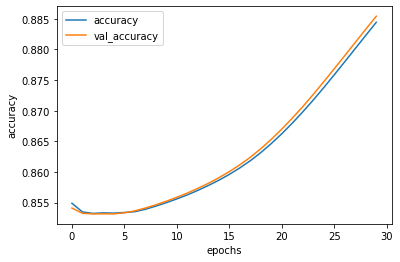

In [43]:
def plot_history(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string],'')
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.legend([string,'val_'+string])
    plt.show()

plot_history(history, 'accuracy')

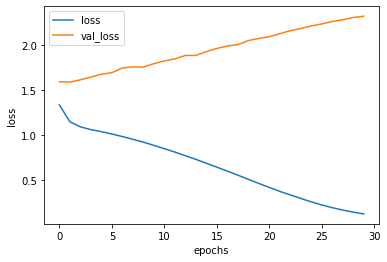

In [44]:
plot_history(history, 'loss')

In [45]:
import re

FILTERS = "([~.,!?\"':;)(])"
CHANGE_FILTER = re.compile(FILTERS) # 미리 Complie
PAD, PAD_INDEX = "<PAD>", 0 # 패딩 토큰
STD, STD_INDEX = "<SOS>", 1 # 시작 토큰
END, END_INDEX = "<END>", 2 # 종료 토큰
UNK, UNK_INDEX = "<UNK>", 3 # 사전에 없음
MARKER = [PAD,STD,END,UNK]
MAX_SEQUNECE = 25

def processing_encoder_input(value, dictionary):
    sequences_input_index = []
    sequences_length = []

    for sequence in value :
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        sequence_index = []
        
        for word in sequence.split():
            if dictionary.get(word) is not None:
                sequence_index.extend([dictionary[word]])
            else:
                sequence_index.extend([dictionary[UNK]])
        
        # truncating      
        if len(sequence_index) > MAX_SEQUNECE:
            sequence_index = sequence_index[:MAX_SEQUNECE]
        
        # padding
        sequences_length.append(len(sequence_index))
        sequence_index += (MAX_SEQUNECE - len(sequence_index)) * [dictionary[PAD]]
        sequences_input_index.append(sequence_index)

    return np.asarray(sequences_input_index), sequences_length

In [46]:
query = "남자친구 승진 선물로 뭐가 좋을까"

test_index_inputs , _ = processing_encoder_input([query],char2idx)
predict_tokens =  model.inference(test_index_inputs)
print(' '.join([idx2char['%s'%t] for  t in predict_tokens]))

평소에 필요했던 게 좋을 것 같아요


In [47]:
query = "나는 어때"

test_index_inputs , _ = processing_encoder_input([query],char2idx)
predict_tokens =  model.inference(test_index_inputs)
print(' '.join([idx2char['%s'%t] for  t in predict_tokens]))

괜찮은 사람이에요
